## Setup

In [3]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
import datetime

import functools
import IPython
import IPython.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp


import glucose_ts

# plot layouts
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 3.5})
sns.color_palette("dark")

plt.subplots_adjust(wspace=1.5)
DATA_DIR = os.path.join(os.path.dirname(os.path.dirname(glucose_ts.__file__)), 'data')


<Figure size 432x288 with 0 Axes>

## Load and Normalize the data


In [4]:
glucose_series = sorted(
    [
        glucose_ts.data.read_glucose_ts(os.path.join(DATA_DIR, file))
        for file in os.listdir(DATA_DIR)
        if file.startswith('Data')
    ] + [
        glucose_ts.data.read_glucose_ts(os.path.join(DATA_DIR, 'batch_samples', file))
        for file in os.listdir(
            os.path.join(
                DATA_DIR,
                'batch_samples'
            )
        )
    ] + [
        glucose_ts.data.read_glucose_ts(os.path.join(DATA_DIR, 'calibration', file))
        for file in os.listdir(
            os.path.join(
                DATA_DIR,
                'calibration'
            )
        )
    ] + [
        glucose_ts.data.read_glucose_ts(os.path.join(DATA_DIR, 'standards_warm', file))
        for file in os.listdir(
            os.path.join(
                DATA_DIR,
                'standards_warm'
            )
        )
    ] + [
        glucose_ts.data.read_glucose_ts(os.path.join(DATA_DIR, 'warm_standards_hamilton', file))
        for file in os.listdir(
            os.path.join(
                DATA_DIR,
                'warm_standards_hamilton'
            )
        )
    ],
    key=lambda one: one.real_concentration
)

selection = glucose_series

volt_mean = np.mean(np.concatenate([one.voltages for one in selection]))
volt_std = np.std(np.concatenate([one.voltages for one in selection]))
time_mean = np.mean(np.concatenate([one.points_in_time for one in selection]))
time_std = np.std(np.concatenate([one.points_in_time for one in selection]))

thinning_factor = 10

normed_series = [
    glucose_ts.data.GlucoseTS(
        voltages=(series.voltages - volt_mean) / volt_std,
        points_in_time=series.points_in_time,
        real_concentration=series.real_concentration,
    )    
    for series in selection
]

len(normed_series), set([one.real_concentration for one in selection])

(85,
 {0.0,
  0.05,
  0.1,
  0.2,
  0.3,
  0.4,
  0.5,
  0.75,
  1,
  1.001,
  1.25,
  1.5,
  2.0,
  2.5,
  5.0,
  5.001,
  5.002,
  7.5,
  10.0})

# Find ODE Parameter for each Curve

As we know the explicit solution we can take a look for the maximum likelihood soltion of the curve fitting problem and plot the solution vs. the fitted curve. We need these parameters for the training process of the neural network later on.



In [4]:
from glucose_ts.models.generalized_logistics import GLParameter

series_model = [
    (
        glucose_ts.models.GeneralizedLogisticGrowth(
            parameter= GLParameter(
                A=2,
                K=-1,
                B=1,
                nu=1,
                M=0
            )
        ).fit(
            series.points_in_time,
            series.voltages,
        ),
        series,
    )   
    for series in normed_series
]

/home/christoph/.virtualenvs/glucose-ts/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/christoph/git_projects/glucose-prediction/glucose_ts/models/generalized_logistics.py:48: RuntimeWarning: divide by zero encountered in true_divide
  (K - A) / (
/home/christoph/git_projects/glucose-prediction/glucose_ts/models/generalized_logistics.py:48: RuntimeWarning: overflow encountered in true_divide
  (K - A) / (
/home/christoph/git_projects/glucose-prediction/glucose_ts/models/generalized_logistics.py:49: RuntimeWarning: overflow encountered in power
  np.power(
/home/christoph/git_projects/glucose-prediction/glucose_ts/models/generalized_logistics.py:50: RuntimeWarning: overflow encountered in exp
  C + Q * np.exp(-B * (time.astype(np.float64) - M)),


In [5]:
len(series_model)

85

/home/christoph/git_projects/glucose-prediction/glucose_ts/models/generalized_logistics.py:49: RuntimeWarning: overflow encountered in power
  np.power(


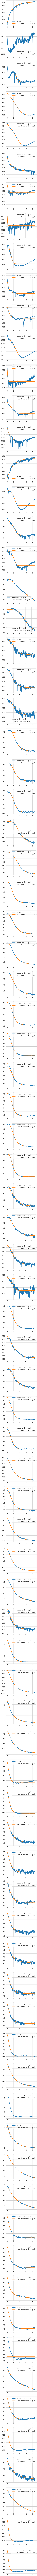

In [6]:
fig, axes = plt.subplots(len(series_model), 1, figsize=(8, len(series_model) * 8))


for ax, (model, series) in zip(
    axes.flatten(),
    series_model
):
    ax.plot(
        series.points_in_time,
        series.voltages,
        label='labels for %4.2f g / L' % series.real_concentration,
    )
    ax.plot(
        series.points_in_time,
        model.predict(series.points_in_time),
        label='predictions for %4.2f g / L' % series.real_concentration,
    )
    ax.legend()

In [7]:
parameter_series = [(model.parameter, series) for model, series in series_model]

In [5]:
import random

CUT_OFF = 10

validation_indices = random.sample(range(len(parameter_series)), k=15)

train_parameter, pure_training = tuple(zip(*[
    (parameter, series.voltages)
    for idx, (parameter, series) in enumerate(parameter_series) 
    if not idx in validation_indices
]))

pure_validation = [
    series.voltages 
    for idx, (_, series) in enumerate(parameter_series)
    if idx in validation_indices
]

print(np.array(pure_training).shape, np.array(pure_validation).shape)

CLUSTER_LENGTH = 10
CUT_OFF_IDX = 15

training = glucose_ts.data.tf_data_windows.training_dataset_with_parameter(
    time_series=pure_training,
    parameter=train_parameter,
    batch_size=32,
    cluster_length=CLUSTER_LENGTH,
)


training_without_parameter = glucose_ts.data.tf_data_windows.sample_time_series_dataset(
    data=pure_training,
    batch_size=32,
    cluster_cut_off_idx=CUT_OFF_IDX,
    cluster_length=CLUSTER_LENGTH,
    all_combinations=False,
    shuffle_data=False
)


validation = glucose_ts.data.tf_data_windows.sample_time_series_dataset(
    data=pure_validation,
    batch_size=32,
    cluster_cut_off_idx=CUT_OFF_IDX,
    cluster_length=CLUSTER_LENGTH,
    all_combinations=False,
    shuffle_data=False
)


NameError: name 'parameter_series' is not defined

5/5 [==============================] - 0s 18ms/step - loss: 0.9814
0.9813704490661621
Epoch 1/20
1000/1000 [==============================] - 28s 18ms/step - loss: 0.1304 - val_loss: 0.3720
Epoch 2/20
1000/1000 [==============================] - 19s 19ms/step - loss: 0.0770 - val_loss: 0.3467
Epoch 3/20
1000/1000 [==============================] - 23s 23ms/step - loss: 0.0437 - val_loss: 0.3290
Epoch 4/20
1000/1000 [==============================] - 26s 26ms/step - loss: 0.0333 - val_loss: 0.3656
Epoch 5/20
1000/1000 [==============================] - 26s 26ms/step - loss: 0.0321 - val_loss: 0.3689
Epoch 6/20
Setting the derivative regulariztion to 1.00E-03
1000/1000 [==============================] - 26s 26ms/step - loss: 0.0311 - val_loss: 0.3711
Epoch 7/20
1000/1000 [==============================] - 26s 26ms/step - loss: 0.0308 - val_loss: 0.3779
Epoch 8/20
1000/1000 [==============================] - 26s 26ms/step - loss: 0.0305 - val_loss: 0.3731
Epoch 9/20
1000/1000 [===========

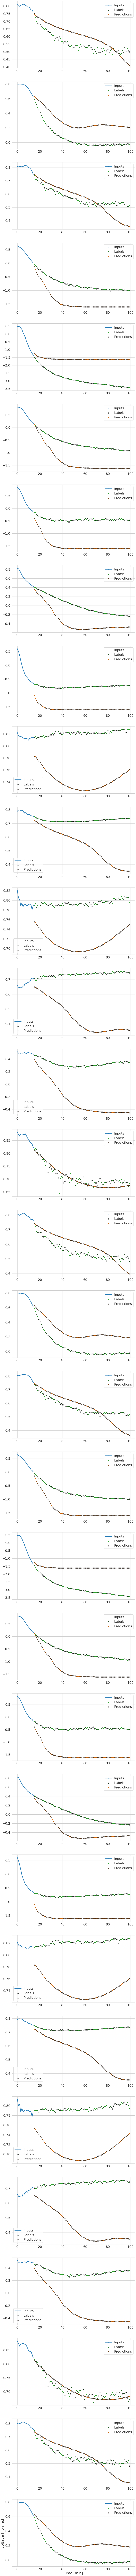

In [13]:
import glucose_ts

val_performance = {}

model = glucose_ts.models.lstm.ODERegularizedLSTM(
    units=10,
    total_length=100,
    label_length=100 - CUT_OFF_IDX,
    lstm_regularization=1e-5,
    dense_regularization=1e-3,
    derivative_regularization=0.,
    norm_mean=0.,
    norm_std=1.,
    delta_t=9. / 100,
#     lstm_dropout=0.05,
#     dense_dropout=0.2,
    dense_layer_sizes=(6, 3), 
)

with tf.device("CPU:0"):
    
    
    model.compile(
#         loss=glucose_ts.models.cost_functions.MSEPlusDerivativeLoss(
#             delta_t=9. / 100,
#             derivative_factor=0.,
#         ),
        loss=tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE),
        optimizer=tf.optimizers.Adam(
            learning_rate=5e-4
        ),
    )
    print(model.evaluate(validation))
    history = model.fit(
        training.shuffle(100).prefetch(tf.data.AUTOTUNE),
        steps_per_epoch=1000,
        epochs=20,
        validation_data=validation,
        callbacks=[
#             tf.keras.callbacks.EarlyStopping(
#                 monitor='val_loss',
#                 patience=10,
#                 mode='min',
#                 restore_best_weights=True,
#             ),
            glucose_ts.models.lstm.ODEDerivativeRegAdapter(
                schedule={
                    0: 0.,
                    5: 1e-3,
                    10: 1e-1,
                    12: 1,
                    14: 5,
                }
            )
        ]
    )
    model.build([None, None, 1])


val_performance['AR LSTM'] = model.evaluate(validation)
model.summary()
glucose_ts.data.plot(validation.shuffle(100).take(1), model)
print('Training Data:')


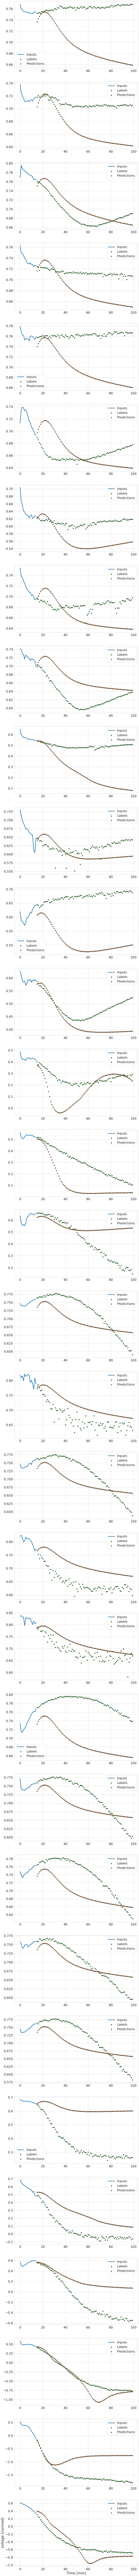

In [69]:
glucose_ts.data.plot(training_without_parameter.take(1), model)

In [9]:
sorted([one.B / one.nu for one in train_parameter])

[3.7248871083148504e-05,
 0.0005659900863810031,
 0.0006343647185174708,
 0.000717538217648143,
 0.024269383175047645,
 0.06056970424923877,
 0.10471592336008184,
 0.12084949669123374,
 0.14688275269682277,
 0.18219023668983772,
 0.9242936156488,
 1.0120625698286272,
 1.086564834433659,
 1.1140144796379996,
 1.158975173201921,
 1.3923445993820405,
 3.5517644560799093,
 3.7403572222090626,
 10.292590308662247,
 10.43615447936104,
 16.575135772585163,
 17.97231128179042,
 28.554244704546292,
 32.34433263102508,
 33.99850310889554,
 39.978891605788824,
 41.40835459892146,
 85.61485986183511,
 98.8136258656722,
 123.83231470883892,
 176.044252848846,
 408.36691412448465,
 474.8986300620683,
 484.58549261447877,
 484.7458317694752,
 664.2831813887493,
 922.8177187619942,
 1145.4366352236384,
 1301.7417878088893,
 1308.0309447828313,
 1502.447932134415,
 1879.0467580853954,
 2912.533777804462,
 3047.568292970678,
 3108.736053691673,
 3490.9627468004865,
 3900.8833448985824,
 3971.59581614303

In [10]:
glucose_ts.models.cost_functions.generalized_logistic_derivative(
    y_pred=np.array([-1e10, 2., 3.])[np.newaxis, :, np.newaxis].astype(np.float32),
    ode_parameter=np.array(train_parameter[0])[np.newaxis, :].astype(np.float32),
    delta_t=9 / 100,
)

<tf.Tensor: shape=(), dtype=float32, numpy=14.025154>

In [11]:
sorted([
    float(
        glucose_ts.models.cost_functions.generalized_logistic_derivative(
            y_pred=pure_training[idx][np.newaxis, ::10, np.newaxis].astype(np.float32),
            ode_parameter=np.array(train_parameter[idx])[np.newaxis, :].astype(np.float32),
            delta_t=9 / 100,
        )
    )
    for idx in range(len(pure_training))
])

[0.0005453636404126883,
 0.0005841840174980462,
 0.0008167554624378681,
 0.0011577245313674212,
 0.0013302891748026013,
 0.0015772766200825572,
 0.0017882653046399355,
 0.0018837966490536928,
 0.0019282193388789892,
 0.001933829509653151,
 0.0020112362690269947,
 0.0021048225462436676,
 0.0021124279592186213,
 0.0021225714590400457,
 0.002220453228801489,
 0.002229769714176655,
 0.0022985371761024,
 0.002345960820093751,
 0.002356099896132946,
 0.0023797822650521994,
 0.0024316764902323484,
 0.0024654793087393045,
 0.0025297661777585745,
 0.002529773162677884,
 0.002600947394967079,
 0.002622920088469982,
 0.0029255133122205734,
 0.003184498753398657,
 0.0032329107634723186,
 0.004363502375781536,
 0.004393997136503458,
 0.004734368063509464,
 0.004854382947087288,
 0.004911552648991346,
 0.005126669071614742,
 0.005138995125889778,
 0.005923843011260033,
 0.006313244346529245,
 0.006613645236939192,
 0.006620266009122133,
 0.006683265324681997,
 0.006798228248953819,
 0.00705304509028

# Using Chen et. alls method

## Creating Datasets

In [5]:
import random

validation_indices = random.sample(range(len(glucose_series)), k=10)

pure_training = [
    series 
    for idx, series in enumerate(glucose_series) 
    if not idx in validation_indices
]
pure_validation = [
    series 
    for idx, series in enumerate(glucose_series)
    if idx in validation_indices
]

print('We have %s training observations and %s validation series' % (len(pure_training), len(pure_validation)))

train_mean = np.mean([one.voltages for one in pure_training])
train_std = np.std([one.voltages for one in pure_training])

normalized_training = [
    glucose_ts.data.GlucoseTS(
        voltages=(one.voltages - train_mean) / train_std,
        points_in_time=one.points_in_time,
        real_concentration=one.real_concentration
    )
    for one in pure_training
]
normalized_validation = [
    glucose_ts.data.GlucoseTS(
        voltages=(one.voltages - train_mean) / train_std,
        points_in_time=one.points_in_time,
        real_concentration=one.real_concentration
    )
    for one in pure_validation
]

We have 75 training observations and 10 validation series


In [17]:
import math
import itertools

tf.keras.backend.set_floatx('float32')


one_series = normed_series[55]


ode_training = glucose_ts.data.tf_data_windows.time_and_volts_dataset(
    series=normalized_training,
    cluster_length=20,
    all_combinations=True,
    data_type=tf.float32,
)
ode_validation = glucose_ts.data.tf_data_windows.time_and_volts_dataset(
    series=normalized_validation,
    cluster_length=20,
    all_combinations=False,
    data_type=tf.float32
)

num_units = 20
batch_size = 64

def train_ode_model(rnn_dropout, dense_dropout, rnn_reg, dense_reg):
    
    print(
        'rnn_dropout: %5.3f \ndense_dropout: %5.3f \nrnn_reg: %.2E \ndense_reg: %.2E' % (
            rnn_dropout, dense_dropout, rnn_reg, dense_reg)
    )

    model = glucose_ts.models.bio_informed.BioInformedNN(
        units=15,
        total_length=50,
        label_length=40,
        rnn_regularization=rnn_reg,
        dense_regularization=dense_reg,
        lstm_dropout=rnn_dropout,
        dense_dropout=dense_dropout,
        dense_layer_sizes=(24, 24, 16, 8,),
        prediction_sampling=5,
        batch_size=batch_size,
    )
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.optimizers.Adam(learning_rate=5e-4),
    )
    history = model.fit(
        ode_training.shuffle(100).batch(batch_size).prefetch(tf.data.AUTOTUNE),
        validation_data=ode_validation.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE),
        epochs=100,
        steps_per_epoch=100,
        callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            mode='min',
            restore_best_weights=True
        )],
        use_multiprocessing=True,
    )
    # model.build((None, ))
    model.summary()
    
    return (model, history)

dropout_results = dict()
dropout_values = [0.005, 0.01, 0.02, 0.04, 0.08, 0.16, 0.32]
reg_values = np.logspace(-8, -4, 10)
combinations = list(itertools.product(reg_values, reg_values))

print('number of combinations is %s' % len(combinations))

with tf.device("GPU:0"):

#     for idx, parameter in enumerate(combinations):
#         print('Number %s of %s' % (idx + 1, len(combinations)))
#         dropout_results[parameter] = train_ode_model(0., 0., *parameter)
    model, _ = train_ode_model(0., 0., 1e-5, 1e-5)

number of combinations is 100
rnn_dropout: 0.000 
dense_dropout: 0.000 
rnn_reg: 1.00E-05 
dense_reg: 1.00E-05
Epoch 1/100
100/100 [==============================] - 34s 280ms/step - loss: 0.3892 - val_loss: 0.1864
Epoch 2/100
100/100 [==============================] - 29s 290ms/step - loss: 0.1013 - val_loss: 0.1791
Epoch 3/100
100/100 [==============================] - 33s 334ms/step - loss: 0.0865 - val_loss: 0.1727
Epoch 4/100
100/100 [==============================] - 44s 440ms/step - loss: 0.0713 - val_loss: 0.2053
Epoch 5/100
100/100 [==============================] - 43s 431ms/step - loss: 0.0615 - val_loss: 0.2249
Epoch 6/100
100/100 [==============================] - 40s 399ms/step - loss: 0.0573 - val_loss: 0.2669
Epoch 7/100
100/100 [==============================] - 39s 386ms/step - loss: 0.0549 - val_loss: 0.2972
Epoch 8/100
100/100 [==============================] - 38s 382ms/step - loss: 0.0519 - val_loss: 0.2759
Epoch 9/100
100/100 [==============================] - 40

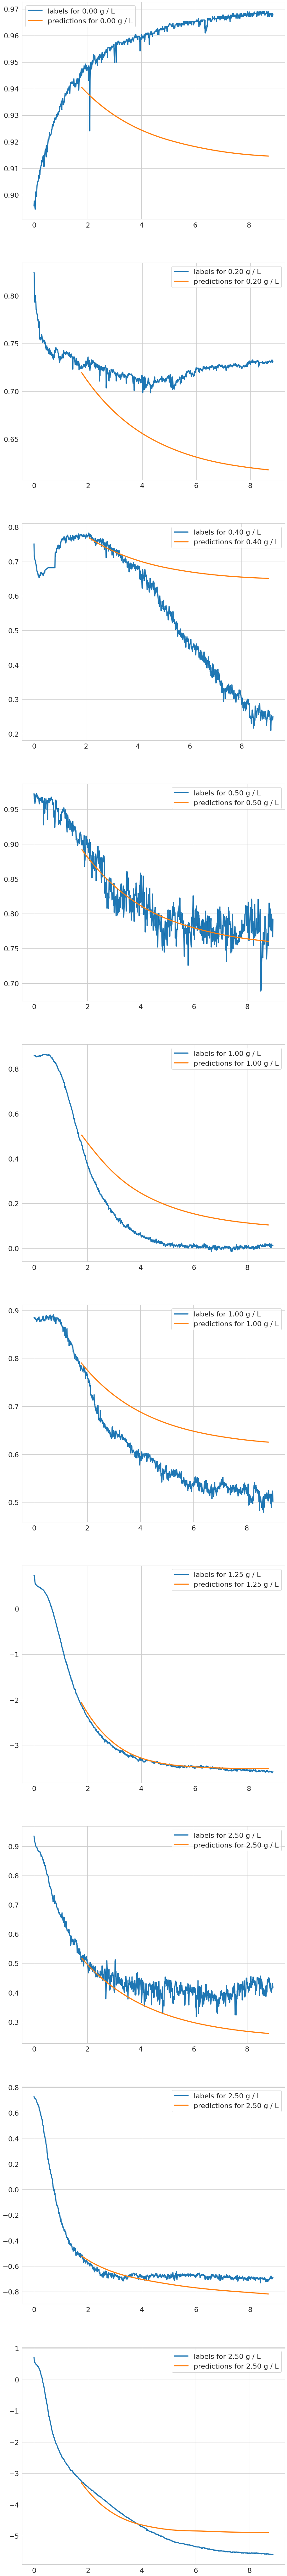

In [37]:

# Plot the results
def plot_ode_model(series, model, cut_off, voltage_sampling):
    
    
    fig, axises = plt.subplots(len(series), 1, figsize=(15, len(series) * 15))
    
    for one_series, ax in zip(series, axises):

        ax.plot(
            one_series.points_in_time,
            one_series.voltages,
            label='labels for %4.2f g / L' % one_series.real_concentration,
        )
        ax.plot(
            one_series.points_in_time[cut_off ::voltage_sampling],
            model(
                (
                    one_series.points_in_time[np.newaxis, (cut_off-1)::voltage_sampling],
                    one_series.voltages[np.newaxis, :cut_off:voltage_sampling]
                )
            )[0, :],
            label='predictions for %4.2f g / L' % one_series.real_concentration,
        )
        ax.legend()

model = dropout_results[(0.005, 0.32)][0]
plot_ode_model(normalized_validation, model, cut_off=200, voltage_sampling=20)
